# Continuous XOR


In this section you will build a simple neural network and train it to classify a dataset representing a continuous XOR (continuous data are generated by introducing some gaussian noise on the binary inputs. Our desired separation of an XOR dataset could look as follows:

<center style="width: 100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/continuous_xor.svg?raw=1" width="350px"></center>


## Perform standard imports

In [2]:
## Standard libraries
# import os
# import math
import numpy as np 
# import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
# import seaborn as sns
# sns.set()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

/tmp/ipykernel_264752/583515522.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


## Generate the data
To generate the data we will use the package `torch.utils.data`, which allows to load the training and test data efficiently.

The data package defines two classes which are the standard interface for handling data in PyTorch: `data.Dataset`, and `data.DataLoader`. The dataset class provides an uniform interface to access the training/test data, while the data loader makes sure to efficiently load and stack the data points from the dataset into batches during training.

#### The dataset class

The dataset class summarizes the basic functionality of a dataset in a natural way. To define a dataset in PyTorch, we simply specify two functions: `__getitem__`, and `__len__`. The get-item function has to return the $i$-th data point in the dataset, while the len function returns the size of the dataset. For the XOR dataset, we can define the dataset class as follows:

In [3]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

Let's try to create such a dataset and inspect it:

In [4]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([0.0129, 0.9812]), tensor(1))


### EXERCISE:  plot the samples below. 

In [5]:
# YOUR CODE HERE
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

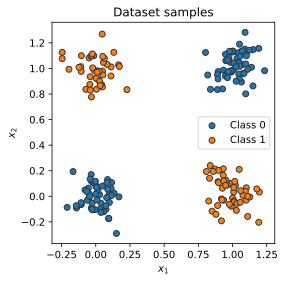

In [6]:
visualize_samples(dataset.data, dataset.label)
plt.show()

### QUICK RECALL: The data loader class

The class `torch.utils.data.DataLoader` represents a Python iterable over a dataset with support for automatic batching, multi-process data loading and many more features. The data loader communicates with the dataset using the function `__getitem__`, and stacks its outputs as tensors over the first dimension to form a batch.
In contrast to the dataset class, we usually don't have to define our own data loader class, but can just create an object of it with the dataset as input. Additionally, we can configure our data loader with the following input arguments (only a selection, see full list [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)):

* `batch_size`: Number of samples to stack per batch
* `shuffle`: If True, the data is returned in a random order. This is important during training for introducing stochasticity. 
* `num_workers`: Number of subprocesses to use for data loading. The default, 0, means that the data will be loaded in the main process which can slow down training for datasets where loading a data point takes a considerable amount of time (e.g. large images). More workers are recommended for those, but can cause issues on Windows computers. For tiny datasets as ours, 0 workers are usually faster.
* `pin_memory`: If True, the data loader will copy Tensors into CUDA pinned memory before returning them. This can save some time for large data points on GPUs. Usually a good practice to use for a training set, but not necessarily for validation and test to save memory on the GPU.
* `drop_last`: If True, the last batch is dropped in case it is smaller than the specified batch size. This occurs when the dataset size is not a multiple of the batch size. Only potentially helpful during training to keep a consistent batch size.

### EXERCISE: create a data loader for the training test and one for the test set

You can create train and test sets separately or create a single dataset and split them using sklearn function. 
Do not forget to import it using `from sklearn.model_selection import train_test_split`.


In [7]:
# YOUR CODE HERE
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = XORDataset(size=500)
test_data_loader = data.DataLoader(test_dataset, batch_size=25, shuffle=True)


In [10]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."

data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the 
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)
for i, (dat, lab) in enumerate(data_loader):
    print(i, dat, )
    

Data inputs torch.Size([8, 2]) 
 tensor([[-0.1053, -0.0648],
        [ 0.8910, -0.0725],
        [ 0.1671,  1.0280],
        [ 0.9774, -0.0628],
        [ 0.8980,  0.1063],
        [-0.0722,  0.8365],
        [ 1.0965,  1.0350],
        [ 0.9485,  1.1110]])
Data labels torch.Size([8]) 
 tensor([0, 1, 1, 1, 1, 1, 0, 0])
0 tensor([[ 8.9099e-01, -7.2479e-02],
        [-7.8697e-02,  5.0363e-02],
        [ 9.4847e-01,  1.1110e+00],
        [ 5.1532e-03,  8.3700e-01],
        [ 4.7261e-02,  1.2683e+00],
        [-1.4539e-02,  1.0996e+00],
        [ 1.7237e-01,  1.0153e+00],
        [ 2.0966e-04,  8.2392e-02]])
1 tensor([[ 0.9258,  0.0629],
        [ 0.9357, -0.0308],
        [ 0.0791, -0.0106],
        [ 1.0965,  1.0350],
        [ 1.1268, -0.0061],
        [ 0.9189, -0.1922],
        [ 0.0281,  0.0119],
        [ 0.9691,  0.9749]])
2 tensor([[-0.0301,  1.0992],
        [ 0.0636,  1.0787],
        [-0.0051, -0.1047],
        [ 1.1512,  1.1473],
        [-0.0513, -0.0166],
        [ 0.9355,  

## Build the model

### EXERCISE:
* Construct the class for minimal network with a input layer, one hidden layer with tanh as activation function, and an output layer. 
* Call an istance of the model using four hidden neurons.
* Print the model and its parameters

In [8]:
# YOUR CODE HERE
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

In [9]:
# YOUR CODE HERE
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)
Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


## Train the model

After defining the model and the dataset, it is time to prepare the optimization of the model. 

Recall that during training, we will perform the following steps:

1. Get a batch from the data loader
2. Obtain the predictions from the model for the batch
3. Calculate the loss based on the difference between predictions and labels
4. Backpropagation: calculate the gradients for every parameter with respect to the loss
5. Update the parameters of the model in the direction of the gradients


#### Loss modules

We can calculate the loss for a batch by simply performing a few tensor operations as those are automatically added to the computation graph. For instance, for binary classification, we can use Binary Cross Entropy (BCE) which is defined as follows:

$$\mathcal{L}_{BCE} = -\sum_i \left[ y_i \log x_i + (1 - y_i) \log (1 - x_i) \right]$$

where $y$ are our labels, and $x$ our predictions, both in the range of $[0,1]$. However, PyTorch already provides a list of predefined loss functions which we can use (see [here](https://pytorch.org/docs/stable/nn.html#loss-functions) for a full list). For instance, for BCE, PyTorch has two modules: `nn.BCELoss()`, `nn.BCEWithLogitsLoss()`. While `nn.BCELoss` expects the inputs $x$ to be in the range $[0,1]$, i.e. the output of a sigmoid, `nn.BCEWithLogitsLoss` combines a sigmoid layer and the BCE loss in a single class. This version is numerically more stable than using a plain Sigmoid followed by a BCE loss because of the logarithms applied in the loss function. Hence, it is adviced to use loss functions applied on "logits" where possible (remember to not apply a sigmoid on the output of the model in this case!). For our model defined above, we therefore use the module `nn.BCEWithLogitsLoss`. 

#### Stochastic Gradient Descent

For updating the parameters, you will use the `torch.optim.SGD` as seen in the prevous sections.

Remember that input to the optimizer are the parameters of the model: `model.parameters()`.


A good default value of the learning rate for a small network as ours is 0.1. 

### EXERCISE: Train your network and evaluate it on the test data

* Train the network for 100 epochs
* Evaluate it simultaneously (do not forget to deactivate gradients using `with torch.no_grad()`).
* Use the accuracy as metric for evaluation. You should also plot the loss function for training and test data set accross epochs

Before starting it is better to redo the following steps:
* Create a train set of 2500 points and batch size 128. Use 500 and batch size 25 for the test
* Creat a new istance of your model and send it to the device


In [10]:
# YOUR CODE HERE
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Push model to device. Has to be only done once
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

loss_module = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Do this in case you did not do it before
# train_dataset = XORDataset(size=2500)
# train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# test_dataset = XORDataset(size=500)
# test_data_loader = data.DataLoader(test_dataset, batch_size=25, shuffle=True)



/home/stef/anaconda3/envs/StableBaselines/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### Training

Finally, we are ready to train our model. As a first step, we create a slightly larger dataset and specify a data loader with a larger batch size. 

HINT: 

1. you can write a small training function. Remember our five steps: load a batch, obtain the predictions, calculate the loss, backpropagate, and update. Here the model should be in training mode. This is done by calling `model.train()`. The training mode is needed to correcly implement BatchNorm and Dropuot.

2. Similarly you can write a evaluate function and call it in the training function. Here the model should be in evaluation mode (use `model.eval()`)



In [11]:
# YOUR CODE HERE

def eval_model(model, data_loader, loss_module):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.
    total_loss = 0.
    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:
            
            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            # Calculate the loss
            loss = loss_module(preds, data_labels.float()) 
            total_loss += loss.item()
            
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1
            
            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]
            
    acc = true_preds / num_preds
#     print(f"Accuracy of the model: {100.0*acc:4.2f}%")
    total_loss /= len(data_loader)
    
    return acc, total_loss

In [12]:
# YOUR CODE HERE

def train_eval_model(model, optimizer, data_loader, loss_module, num_epochs=100):

    losses_training = []
    losses_test = []
    accuracies_test = []

        
    # Training loop
#     for epoch in tqdm(range(num_epochs)):
    for epoch in range(num_epochs):
        # Set model to train mode
        model.train() 
        total_loss_training = 0.
        
        # This loop will be repeated len(data_loader) times
        for data_inputs, data_labels in data_loader:
                        
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())
            total_loss_training += loss.item()
            
            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero. 
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad() 
            # Perform backpropagation
            loss.backward()
            
            ## Step 5: Update the parameters
            optimizer.step()
            
        ## Save loss history for each epoch, 
        losses_training.append(total_loss_training / len(data_loader))  
        ## Evaluate the loss and the accuracy during each epoch
        acc_test, total_loss_test = eval_model(model, test_data_loader, loss_module) 
        
        losses_test.append(total_loss_test)
        accuracies_test.append(acc_test.item())
        
    return losses_training, losses_test, accuracies_test
        

In [13]:
losses_training, losses_test, accuracies_test = train_eval_model(
    model, optimizer, train_data_loader, loss_module)
# train_evaluate_model(
#     model, optimizer, train_data_loader, loss_module)

### EXERCISE: plot the losses and accuracy

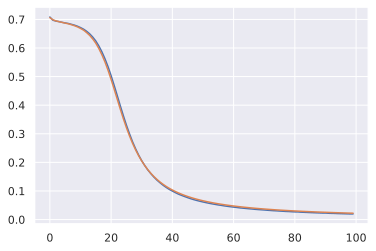

In [14]:
plt.plot(losses_training)
plt.plot(losses_test)

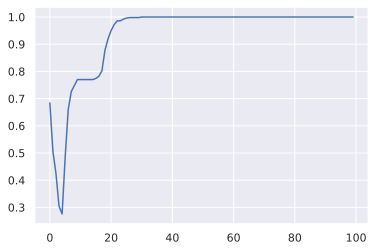

In [15]:
plt.plot(accuracies_test)

If we trained our model correctly, we should see a score close to 100% accuracy. However, this is only possible because of our simple task, and unfortunately, we usually don't get such high scores on test sets of more complex tasks.

### EXERCISE: save the model and reload it

In [16]:
# SAVE THE MODEL
state_dict = model.state_dict()
print(state_dict)
# torch.save(object, filename). For the filename, any extension can be used
torch.save(state_dict, "our_model.tar")
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("our_model.tar")

# Create a new model and load the state
new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

# A detailed tutorial on saving and loading models in PyTorch 
# can be found [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

OrderedDict([('linear1.weight', tensor([[-3.3101,  2.7893],
        [ 0.3768,  0.5265],
        [-2.6314,  3.2156],
        [-1.6891, -1.6443]])), ('linear1.bias', tensor([-1.2620, -0.8886,  1.1641,  0.1377])), ('linear2.weight', tensor([[ 4.4947, -0.8373, -4.3735, -2.4859]])), ('linear2.bias', tensor([1.9437]))])
Original model
 OrderedDict([('linear1.weight', tensor([[-3.3101,  2.7893],
        [ 0.3768,  0.5265],
        [-2.6314,  3.2156],
        [-1.6891, -1.6443]])), ('linear1.bias', tensor([-1.2620, -0.8886,  1.1641,  0.1377])), ('linear2.weight', tensor([[ 4.4947, -0.8373, -4.3735, -2.4859]])), ('linear2.bias', tensor([1.9437]))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[-3.3101,  2.7893],
        [ 0.3768,  0.5265],
        [-2.6314,  3.2156],
        [-1.6891, -1.6443]])), ('linear1.bias', tensor([-1.2620, -0.8886,  1.1641,  0.1377])), ('linear2.weight', tensor([[ 4.4947, -0.8373, -4.3735, -2.4859]])), ('linear2.bias', tensor([1.9437]))])


### EXERCISE: visualize the classification boundaries using the model just loaded

To visualize what our model has learned, we can perform a prediction for every data point in a range of $[-0.5, 1.5]$, and visualize the predicted class as in the sample figure at the beginning of this section. This shows where the model has created decision boundaries, and which points would be classified as $0$, and which as $1$. We therefore get a background image out of blue (class 0) and orange (class 1). 

In [1]:
# YOUR CODE HERE
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
    
    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
#     xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy   
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()

NameError: name 'torch' is not defined